In [2]:
import sys, os



%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
from simulation_engine.algorithms.zhang_bareinboim import ZhangBareinboim
from simulation_engine.algorithms.apid import Apid
from simulation_engine.algorithms.apid_src.src.models.apid import APID

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds
from hydra import compose, initialize
from omegaconf import OmegaConf

C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\apid.py:233: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name=f'config.yaml', config_path='./apid_src/config/')


# ContinousIV Test

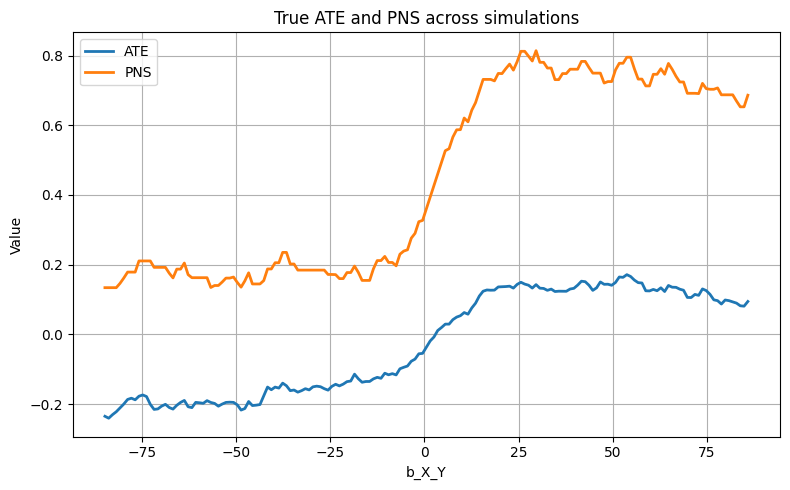

In [64]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-100, 100), N_points=200, replications=1, n=500,
)
PlottingUtil.plot_ate_pns(data,window=30)

In [71]:
data = ContinuousIV.run_rolling_b_X_Y_simulations(
        b_range=(-2, 5), N_points=1, replications=1, n=500,                               )

algs = ['ATE_zaffalonbounds-binned']
contIV = ContinuousIV('IV Dag', data)
contIV.run(algs)
# contIV.binaryIV.data
contIV.data

Running ATE_zaffalonbounds-binned...
Entering binned Binary IV Scenario for algorithm: ATE_zaffalonbounds
Running ATE_zaffalonbounds...


: 

                Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
            ATE_2SLS-0.99         26.50            17.69          1.2833      1.5664
      ATE_zhangbareinboim           N/A              N/A             N/A         NaN
   ATE_causaloptim-binned           N/A              N/A             N/A         NaN
     ATE_autobound-binned           N/A              N/A             N/A         NaN
ATE_zaffalonbounds-binned           N/A              N/A             N/A         NaN
            ATE_2SLS-0.98           N/A              N/A             N/A         NaN
            ATE_2SLS-0.95           N/A              N/A             N/A         NaN


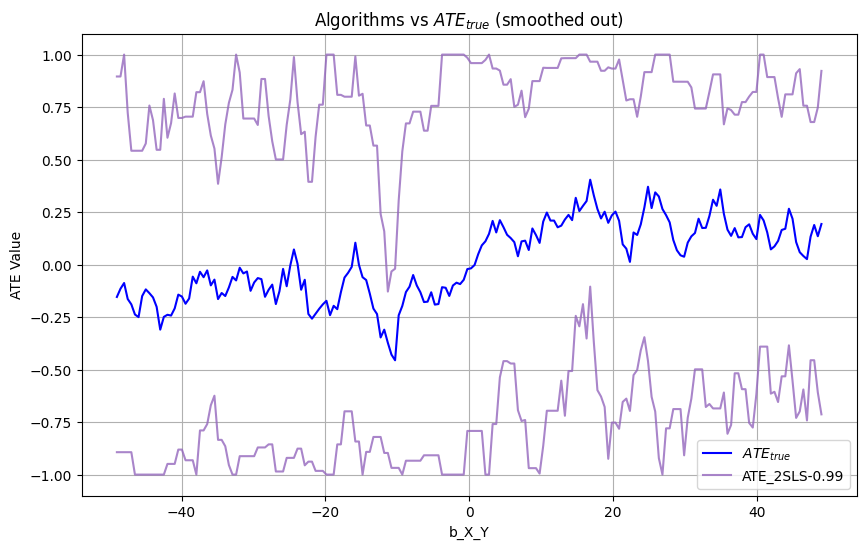

In [42]:
algs = contIV.get_algorithms('ATE')
PlottingUtil.print_bound_statistics_table(contIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(contIV.data, 'ATE', algs, 5)

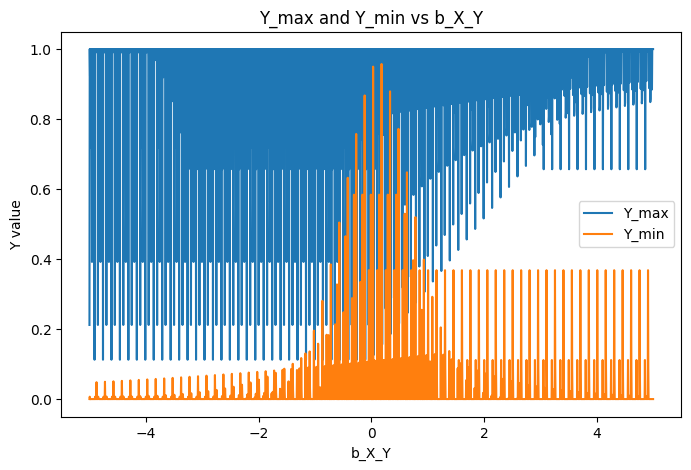

In [107]:
import matplotlib.pyplot as plt

y_label = 'Y'
plt.figure(figsize=(8, 5))
plt.plot(data['b_X_Y'], data[f'{y_label}_max'], label=f'{y_label}_max')
plt.plot(data['b_X_Y'], data[f'{y_label}_min'], label=f'{y_label}_min')
# plt.plot(data['b_X_Y'], data[f'{y_label}_mean'], 'o-', label=f'{y_label}_mean')
plt.xlabel('b_X_Y')
plt.ylabel(f'{y_label} value')
plt.title(f'{y_label}_max and {y_label}_min vs b_X_Y')
plt.legend()
plt.show()

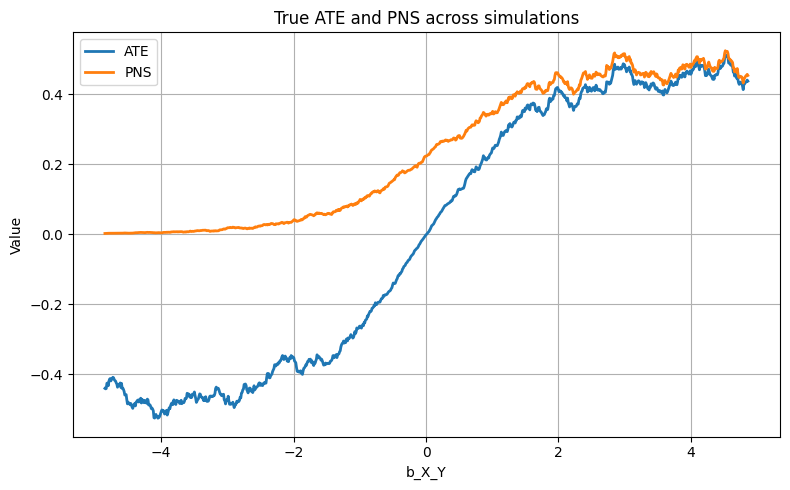

In [49]:
data = BinaryIV.generate_data_rolling_ate(1000, b_lower=-5, b_upper=5)

PlottingUtil.plot_ate_pns(data, window=30)

In [14]:
data = BinaryIV.generate_data_rolling_ate(1)
binaryIV = BinaryIV('IV Dag', data)
algs = ['ATE_zaffalonbounds']

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run(algs)

Running ATE_zaffalonbounds...
ATE_zaffalonbounds completed in 18.52 seconds.
Total runtime: 18.52 seconds.


In [15]:
algorithms = list(runtimes['runtimes'].keys())
ate_algs = binaryIV.get_algorithms('ate')
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'ATE', algs, 5, False)

         Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
ATE_zaffalonbounds          0.00             0.00          0.5236      0.5236
Error: The 'b_X_Y' column has constant or invalid values. Cannot plot.
